In [1]:
import cv2
import custom_dataset
import json
import numpy as np
import torch
import torch.nn as nn
import torchvision

from matplotlib import pyplot as plt
from postprocessing_utils import compare_pred_w_gt_boxes_only, get_consistency_boxes_only
from tqdm.notebook import tqdm

In [2]:
MOT15_TRAIN_PATH = os.path.join('../A/', 'MOT15/train/')
GT_SUBPATH = 'gt/'
IMG_SUBPATH = 'img1/'
OUTPUT_DIR = 'experiment_results'

TARGET_DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

EXPERIMENTS_TO_RUN = {
    "regular": None, # DO NOT EDIT THIS ONE
    "horizontal flip": custom_dataset.ApplyHorizontalFlip(),
    "boost contrast": custom_dataset.ApplySkimageGammaCorrection(),
    "Gaussian denoise": custom_dataset.ApplySkimageGaussian(),
    "unsharp mask": custom_dataset.ApplySkimageUnsharpMask(),
    ".webp compress":custom_dataset.ApplyWebpCompress(),
}

MODELS_TO_USE = {
    "Faster-RCNN":  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, num_classes=91).eval(),
    "SSD": torchvision.models.detection.ssd300_vgg16(pretrained=True, num_classes=91).eval(),
    "RetinaNet": torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True, num_classes=91).eval(),
    "Mask-RCNN": torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=91).eval()
}

C:\Users\tung3\Anaconda3\envs\context-cv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
def draw_missed_bboxes_on_img_and_save(cv2_img, misses, gt_bbox_ids, gt_bboxes, save_path:str, color_bgr:tuple=(0, 0, 255), bbox_thickness:int=10, save=True):
    for bbox_id, bbox in zip(gt_bbox_ids, gt_bboxes):
        if bbox_id in misses:
            cv2_img = cv2.rectangle(cv2_img, tuple(bbox[0:2]), tuple(bbox[2:4]), color_bgr, bbox_thickness)
                
    if save == True:
        cv2.imwrite(save_path, cv2_img)
    return cv2_img

def get_consistency_and_accuracy_for_MOT(model: nn.Module, dataset_transform, output_root: str, show_dataset_samples: bool=True) -> tuple:
    try:
        os.mkdir(output_root)
    except Exception as e:
        pass
    if show_dataset_samples:
        unmodified_mot_dataset = custom_dataset.MOT2015(MOT15_TRAIN_PATH, transform=None)
        print("ORIGINAL IMAGE")
        plt.figure(figsize=(30,30))
        for i in range(5):
            unmodifed_img = unmodified_mot_dataset[i]["img"]
            plt.subplot(2, 5, i+1).axis("off")
            plt.imshow(unmodifed_img)
        plt.show()
        print("MODIFIED IMAGE")
        plt.figure(figsize=(30,30))
        for i in range(5):
            modified_sample = dataset_transform(unmodified_mot_dataset[i])
            modified_img = modified_sample["img"]
            # print(modified_img)
            cv2_img = cv2.cvtColor((modified_img).astype("uint8"), cv2.COLOR_RGB2BGR)
            cv2_img = draw_missed_bboxes_on_img_and_save(cv2_img, modified_sample["bbox_ids"], modified_sample["bbox_ids"], modified_sample["bboxes"], "", save=False)
            cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, 5, i+1+5).axis("off")
            plt.imshow(cv2_img)
        plt.show()
    
    if dataset_transform is not None:
        dataset_transform = torchvision.transforms.Compose([dataset_transform, custom_dataset.ToTensor()])
    else:
        dataset_transform = custom_dataset.ToTensor()
    mot_dataset = custom_dataset.MOT2015(MOT15_TRAIN_PATH, transform=dataset_transform)
    # mot_dataloader = torch.utils.data.DataLoader(mot_dataset, batch_size=1, shuffle=False, num_workers=0)

    folder_name_of_prev_sample = ""
    matches_prev = set()
    gt_bbox_ids_prev = set()
    model = model.to(TARGET_DEVICE)

    accuracies = {}
    consistencies = {}
    
    for i, sample in tqdm(enumerate(mot_dataset)):
        predictions = model([sample["img"].to(TARGET_DEVICE)])[0] # Retrieve the single element in the prediction list
        # print(predictions)
        pred_boxes = predictions["boxes"].to("cpu")
        pred_scores = predictions["scores"].to("cpu")
        gt_boxes = sample["bboxes"]
        gt_bbox_ids = sample["bbox_ids"]
        gt_boxes_tensor = torch.Tensor(gt_boxes)
        gt_bbox_ids_tensor = torch.Tensor(gt_bbox_ids)
        folder_name = sample["folder_name"]
        img_name = sample["img_name"]

        if len(gt_boxes_tensor.shape) == 1: # only 1 dimension, i.e. only 1 box:
            gt_boxes_tensor.unsqueeze(0)

        if len(gt_bbox_ids) == 0: # No ground truth!
            matches = set()
            accuracy = 1.0
        else:
            matches, num_preds= compare_pred_w_gt_boxes_only(pred_boxes, pred_scores, gt_boxes_tensor, gt_bbox_ids_tensor)
            if num_preds == 0:
                accuracy = 0.0
            else:
                accuracy = len(matches) / len(gt_bbox_ids) * len(matches) / num_preds

        if folder_name_of_prev_sample == folder_name:
            missed_matches_in_prev, missed_matches_in_curr, consistency = get_consistency_boxes_only(gt_bbox_ids_prev, matches_prev, set(gt_bbox_ids), matches)
            total_missed_matches = missed_matches_in_prev.union(missed_matches_in_curr)

            if len(total_missed_matches) > 0:
                cv2_img = sample["img"].numpy().transpose((1, 2, 0)) * 255 # Switch to channels-last, rescale up
                cv2_img = cv2.cvtColor(cv2_img.astype(np.uint8), cv2.COLOR_RGB2BGR) # Switch from RGB to BGR
                draw_missed_bboxes_on_img_and_save(cv2_img, total_missed_matches, gt_bbox_ids, gt_boxes, os.path.join(output_root, folder_name, img_name))

            consistencies[folder_name].append(consistency)
        else: # Starting a new folder
            accuracies[folder_name] = []
            consistencies[folder_name] = []
            try:
                os.mkdir(os.path.join(output_root, folder_name))
            except Exception as e:
                pass

        accuracies[folder_name].append(accuracy)
        
        matches_prev = matches
        gt_bbox_ids_prev = set(gt_bbox_ids)
        folder_name_of_prev_sample = folder_name

    with open(os.path.join(output_root, "accuracies.json"), "w") as accuracies_file:
        json.dump(accuracies, accuracies_file)
    with open(os.path.join(output_root, "consistencies.json"), "w") as consistencies_file:
        json.dump(consistencies, consistencies_file)
    
    return consistencies, accuracies

EXPERIMENT: Faster-RCNN, regular



    KITTI-17 Avg. Consistency: 0.940
    KITTI-17 Avg. Accuracy: 0.371
EXPERIMENT: Faster-RCNN, horizontal flip
ORIGINAL IMAGE


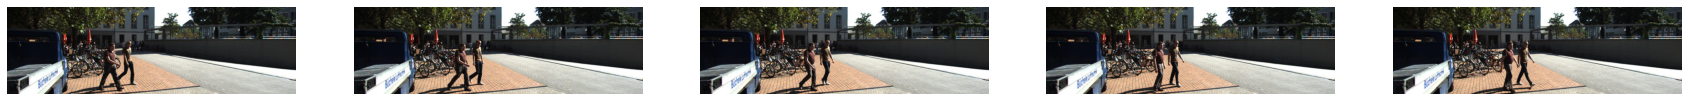

MODIFIED IMAGE


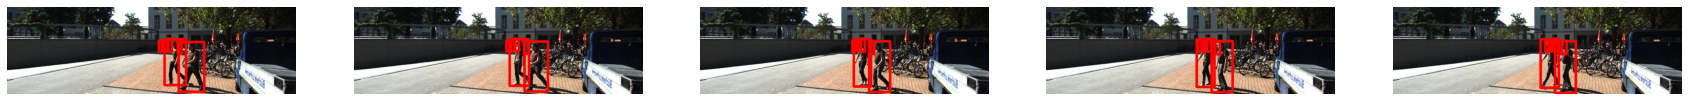


    KITTI-17 Avg. Consistency: 1.000
    KITTI-17 Avg. Accuracy: 0.000
EXPERIMENT: Faster-RCNN, boost contrast
ORIGINAL IMAGE


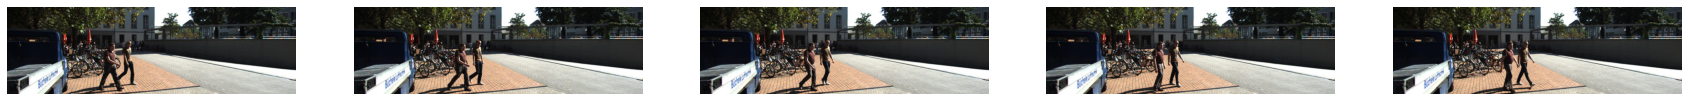

MODIFIED IMAGE


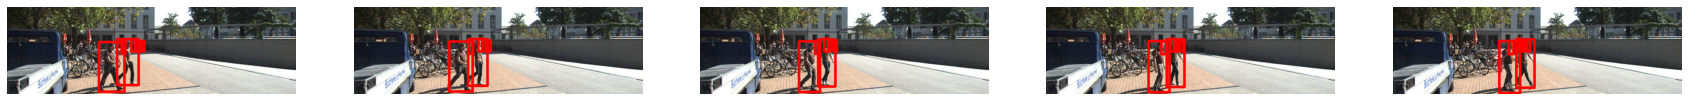


    KITTI-17 Avg. Consistency: 0.940
    KITTI-17 Avg. Accuracy: 0.342
EXPERIMENT: Faster-RCNN, Gaussian denoise
ORIGINAL IMAGE


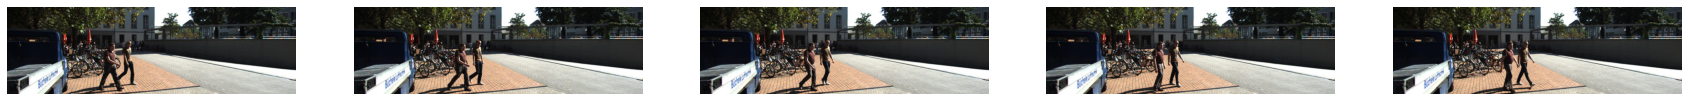

MODIFIED IMAGE
c:\Users\tung3\OneDrive - purdue.edu\consistency\custom_dataset.py:54: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  filtered_img = filters.gaussian(img, preserve_range=True)


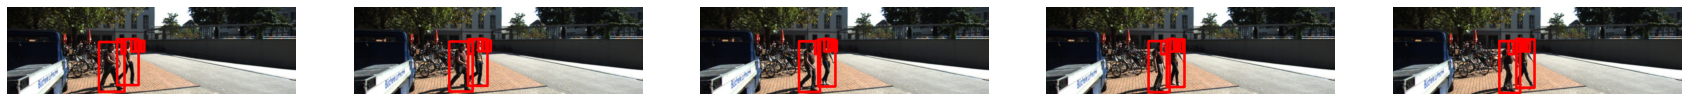


    KITTI-17 Avg. Consistency: 0.937
    KITTI-17 Avg. Accuracy: 0.381
EXPERIMENT: Faster-RCNN, unsharp mask
ORIGINAL IMAGE


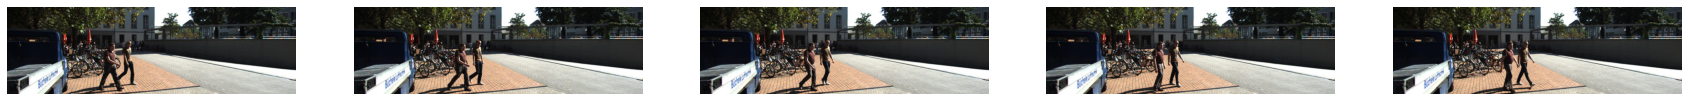

MODIFIED IMAGE


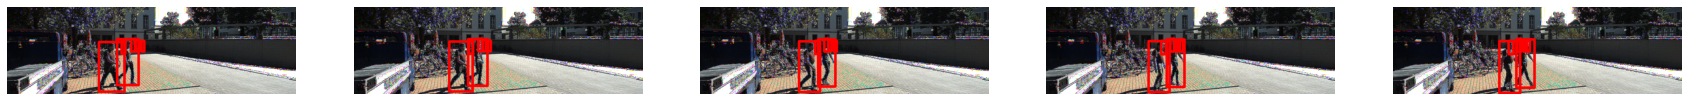


    KITTI-17 Avg. Consistency: 0.865
    KITTI-17 Avg. Accuracy: 0.464
EXPERIMENT: Faster-RCNN, .webp compress
ORIGINAL IMAGE


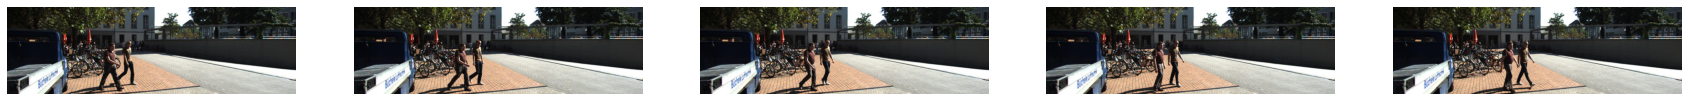

MODIFIED IMAGE


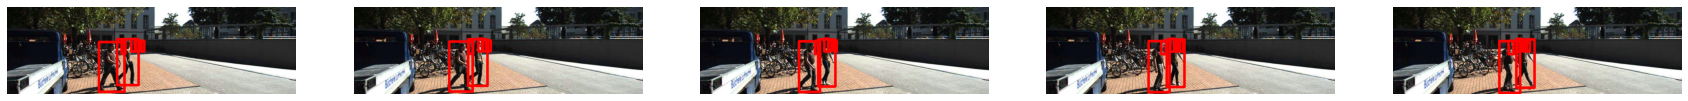


    KITTI-17 Avg. Consistency: 0.936
    KITTI-17 Avg. Accuracy: 0.411
EXPERIMENT: SSD, regular



    KITTI-17 Avg. Consistency: 0.934
    KITTI-17 Avg. Accuracy: 0.057
EXPERIMENT: SSD, horizontal flip


KeyboardInterrupt: 

In [4]:
for model_name in MODELS_TO_USE:
    try:
        os.mkdir(os.path.join(OUTPUT_DIR, model_name))
    except Exception as e:
        pass
    for experiment_name in EXPERIMENTS_TO_RUN:
        try:
            os.mkdir(os.path.join(OUTPUT_DIR, model_name, experiment_name))
        except Exception as e:
            pass
        show_imgs = True if (model_name == "Faster-RCNN" and experiment_name != "regular") else False

        print("EXPERIMENT: {0}, {1}".format(model_name, experiment_name))
        consistencies, accuracies = get_consistency_and_accuracy_for_MOT(MODELS_TO_USE[model_name], EXPERIMENTS_TO_RUN[experiment_name], os.path.join(OUTPUT_DIR, model_name, experiment_name), show_imgs)

        for folder_name in consistencies:
            print("    {0} Avg. Consistency: {1:.3f}".format(folder_name, sum(consistencies[folder_name])/len(consistencies[folder_name])))
            print("    {0} Avg. Accuracy: {1:.3f}".format(folder_name, sum(accuracies[folder_name])/len(accuracies[folder_name])))